In [1]:
import numpy as np
from matplotlib import pyplot as plt

import os
import pickle
from time import time
from sklearn.decomposition import PCA

import george
from george import kernels
from scipy.optimize import minimize

%matplotlib inline

In [2]:
param_names = ["T_star","logL_star","logM_disk","logR_disk","h_0","logR_in",\
          "gamma","beta","logM_env","logR_env","f_cav","ksi","loga_max","p","incl"]

ranges = [[3000.,5000.], [-1,3.],[-8.,-2.], [0.,3.],[0.01,0.5],[-1.,2.5],[0.0,2.0],\
        [0.5,2.0],[-8.,-2.],[2.5,4.], [0.,1.], [0.5,1.5],[0.,5.],[2.5,4.5],[0.,90.]]
steps=[]
bases=[]
for i in range(len(ranges)):
    steps.append(np.linspace(ranges[i][0],ranges[i][1],11))
    bases.append(steps[i][5])

# get all model data
with open ('../grid_metadata/corefull.txt', 'rb') as fp:
    core= pickle.load(fp)[100:500]
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))[:,100:500]
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))[:,100:500]
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)[100:500]

# fix -infs: powerlaw cutoff
for i in range(len(cube)):
    if -np.inf in cube[i]:
        a = cube[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = cube[i][ind]
        for j in range(ind):
            cube[i][j]=(100*(np.log10(xvals[j]/x1)))+y1
            
# nan cutoff for means            
nancube[nancube<-20]=np.nan

In [3]:
# subtracting from the seds each sample mean
seds_msub = cube - np.nanmean(nancube,axis=1)[:,np.newaxis]

t0 = time()
pca = PCA(n_components=40).fit(seds_msub)
print("done in %0.3fs" % (time() - t0))

eigenseds=np.array(pca.components_)

done in 0.091s


In [4]:
# slices - read in filenames and logspace flux values
with open ('../grid_metadata/slicenames.txt', 'rb') as fp:
    slicenames = pickle.load(fp)
with open ('../grid_metadata/slicevals.txt', 'rb') as fp:
    slicevals = pickle.load(fp)[:,:,100:500]
with open ('../grid_metadata/slicevals.txt', 'rb') as fp:
    nanslicevals = pickle.load(fp)[:,:,100:500]

# fix -infs: powerlaw cutoff
for i in range(len(slicevals)):
    for j in range(len(slicevals[i])):
        if -np.inf in slicevals[i][j]:
            a = slicevals[i][j].tolist()
            a.reverse()
            ind = len(a)-a.index(-np.inf)
            x1 = xvals[ind]
            y1 = slicevals[i][j][ind]
            for m in range(ind):
                slicevals[i][j][m]=(100*(np.log10(xvals[m]/x1)))+y1
                
nanslicevals[nanslicevals<-20]=np.nan

slice_seds_msub = slicevals - np.nanmean(nanslicevals,axis=2)[:,:,np.newaxis]

In [5]:
fitdata=[]

for i in range(len(param_names)):
    fitdata.append([])
for i in range(len(param_names)):
    for j in range(11):
        modeldata=[]
        paramval=steps[i][j]
        coeffs=pca.transform(slice_seds_msub[i][j].reshape(1,-1))
        modeldata.append(paramval)
        for k in range(10):
            modeldata.append(coeffs[0][k])
        fitdata[i].append(modeldata)

In [6]:
paramvals=[]
weights=[]
for param in range(15):
    pl=[]
    wl=[]
    for model in range(11):
        pl.append(fitdata[param][model][0])
    paramvals.append(pl)
    
    for w in range(10):
        wsl=[]
        for model in range(11):
            wsl.append(fitdata[param][model][w+1])
        wl.append(wsl)
    weights.append(wl)

In [7]:
def load_pcwpar(param,weight):
    return np.array(paramvals[param]).reshape(-1,1), np.array(weights[param][weight])

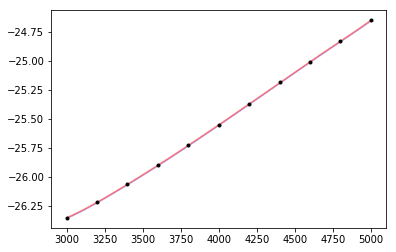

Initial ln-likelihood: -2822.61


In [8]:
X, y = load_pcwpar(0,0)

kernel = kernels.ExpSquaredKernel(900**2)* np.var(y)
gp = george.GP(kernel)
yerr=[j*0.00001 for j in y]
gp.compute(X,yerr)

x_pred = np.linspace(3000,5000,500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="b", alpha=0.2)
plt.plot(x_pred, pred, "r", lw=1.5, alpha=0.5)
plt.errorbar(X, y,yerr,fmt=".k", capsize=0)
plt.show()

print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

      fun: 249.61957844980589
 hess_inv: array([[0.44134573, 0.05216992],
       [0.05216992, 0.02268039]])
      jac: array([ 0.00021261, -0.00062561])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 129
      nit: 17
     njev: 119
   status: 2
  success: False
        x: array([ 5.46538683, 15.04061967])

Final ln-likelihood: -249.62


<ErrorbarContainer object of 3 artists>

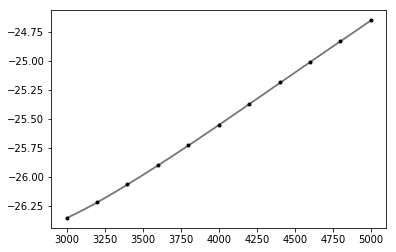

In [9]:
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(X, y, fmt=".k", capsize=0)

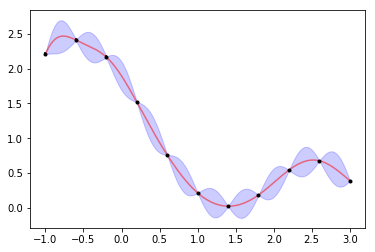

Initial ln-likelihood: -15.13


In [10]:
X, y = load_pcwpar(1,6)
yerr=[j*0.01 for j in y]

kernel = kernels.ExpSquaredKernel(.3**2) * np.var(y)

gp = george.GP(kernel)
gp.compute(X,yerr)

x_pred = np.linspace(-1,3,500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="b", alpha=0.2)
plt.plot(x_pred, pred, "r", lw=1.5, alpha=0.5)
plt.errorbar(X, y, yerr,fmt=".k", capsize=0)
plt.show()

print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

      fun: -3.5040556114614034
 hess_inv: array([[0.32758461, 0.04821   ],
       [0.04821   , 0.02551284]])
      jac: array([ 3.56902852e-07, -9.44599560e-06])
  message: 'Optimization terminated successfully.'
     nfev: 60
      nit: 10
     njev: 59
   status: 0
  success: True
        x: array([ 0.08228214, -0.25366164])

Final ln-likelihood: 3.50


<ErrorbarContainer object of 3 artists>

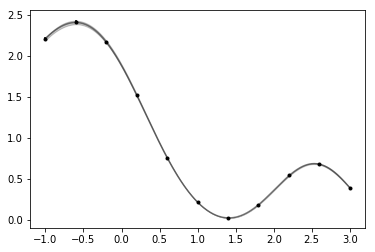

In [11]:

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(X, y, yerr, fmt=".k", capsize=0)

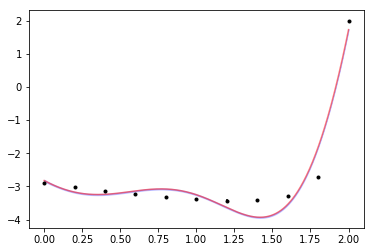

Initial ln-likelihood: -1350.28


array([1.50515521, 1.        ])

In [14]:
X, y = load_pcwpar(6,4)
yerr=[j*0.01 for j in y]

kernel = kernels.ExpSquaredKernel(1**2)* np.var(y)
gp = george.GP(kernel)
gp.compute(X,yerr)

x_pred = np.linspace(0,2,500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="b", alpha=0.2)
plt.plot(x_pred, pred, "r", lw=1.5, alpha=0.5)
plt.errorbar(X, y, yerr,fmt=".k", capsize=0)
plt.show()

print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))
np.sqrt(np.exp(gp.get_parameter_vector()))

      fun: 20.460645849026285
 hess_inv: array([[0.52151341, 0.18031438],
       [0.18031438, 0.09636587]])
      jac: array([-7.13013613e-08,  9.61365458e-08])
  message: 'Optimization terminated successfully.'
     nfev: 22
      nit: 19
     njev: 22
   status: 0
  success: True
        x: array([ 2.43207023, -2.54040708])

Final ln-likelihood: -20.46


<ErrorbarContainer object of 3 artists>

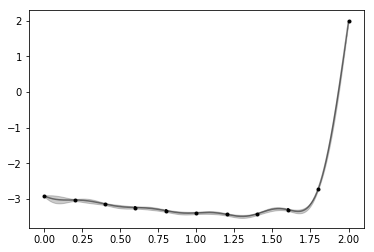

In [15]:

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(X, y, yerr, fmt=".k", capsize=0)

/users/eteng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


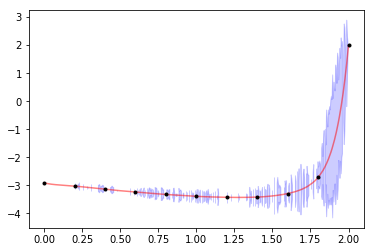

Initial ln-likelihood: -118.89


array([1.50515521, 3.00416602])

In [12]:
X, y = load_pcwpar(6,4)
yerr=[j*0.01 for j in y]

kernel = kernels.PolynomialKernel(2.2,13) * np.var(y)

gp = george.GP(kernel)
gp.compute(X,yerr)

x_pred = np.linspace(0,2,500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="b", alpha=0.2)
plt.plot(x_pred, pred, "r", lw=1.5, alpha=0.5)
plt.errorbar(X, y, yerr,fmt=".k", capsize=0)
plt.show()

print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))
np.sqrt(np.exp(gp.get_parameter_vector()))

      fun: 9.811684039554526
 hess_inv: array([[ 2.22712101, -0.18665168],
       [-0.18665168,  0.01850141]])
      jac: array([4.65661287e-10, 8.73114914e-09])
  message: 'Optimization terminated successfully.'
     nfev: 26
      nit: 12
     njev: 26
   status: 0
  success: True
        x: array([-16.20198696,   1.30763549])

Final ln-likelihood: -9.81


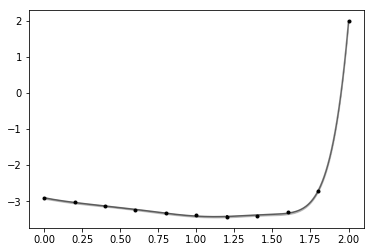

[3.03237728e-04 1.92286785e+00]


In [13]:
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(X, y, yerr, fmt=".k", capsize=0)
plt.show()
print(np.sqrt(np.exp(gp.get_parameter_vector())))